In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn

#### Brainstorming
I need to make sure that I tackle this information problem efficiently. Thus my cycle is:

1) Read relevant information
1) Defining north-star requirements 
2) Asking questions 
4) Answering questions with current & exteral resources

It can be non-linear and for steps 3 and 4 it usually is. \
Read Case + Glance at Data -> Define general tasks I need to do (say what actually is on final slides) -> Ask questions that will get me there -> EDA is guided by questions

#### EDA General Notes

IMPORTANT: This data is of TIMESERIES. Each partner and postid combination is the viewing of said partner in social media! The 'snapshot' date is the time in which the data of how a partner's sponsorship is captured overtime. Each entry is duplicated, only differing by the brandexposurevalue.
- I am starting to think the 'partner_exposure_date' is when the partner showed the AD and the shapshot date is far in the future to see what has occured since then. Usually 3+ months later. Maybe to catch stragglers -> When summarizing, should use the last entry to get the more "wholistic" number. But can also show overtime impressions (cumulative).

How can everything but the exposure_id and brand_exposure_value be the same for an entry? -> Remove these duplicated rows. For rows with the same post_id, exposure_id, and snapshot_time, take the one with the larger brand_exposure_value
- Ok so for the fanduel case I found that they had different exposure_id but same post_id. Maybe the brands logo is duplicated near eachother in a sports broadcast. But if they we duplicated, why have the same Post_ID -> maybe its the same design and the exposure_id details the specific implementations. (i.e. class vs. instances of a class) Very common
- Usually a unique pair of exposure_id + post_id will have 5 snapshots. two that are a day or less apart then three more that are spaced a week apart each. Likely to get more spread and such.

#### EDA Notes - Social Data
Overall I am getting the sense that while some may be dedicated ADs, many are likely brand apperances in streaming services. I think this because of the 'asset' category detailing where a company may show up. ~~But I believe traditional ads are also included because Twitter + Text catgories of ads exist, and these are likely not excerpts from the game but from sports pages that CREATE these ads.~~ Games are streamed on muliple platforms. I am thinking partners showing up in social media can fall into three catagories: we own the page and it is part of a specific campaign, we own the page and we put out content (but not specific to a compaign or partner; incidental exposure), or we do not own the page + content is put out that may incidently contain the partner.

**The 'contenttype' is the type of media (photo, video, text) shared by a page. -> Only twitter has the 'text' contenttype, and YT only appears under 'video' contenttype. The 'asset' is where the partners branding will appear in said media.**

- 'snapshot_date' is likely the time that the ad was exposed to watchers. Range is fairly small.
- 'partnerexposuredate' could be the date at which the partner saw the ad, gave it the greenlight, and allowed it to be used for marketing. All 'snapshot_date' entries occur AFTER their corresponding 'partnerexposuredate'
- 'contenttype' has full coverage and can be video (FB, Twitter, YT), text (Twitter), or photo (FB, Twitter). 
- 'postid' likely refers to the specific piece of media that is being pushed (i.e. unique ad)
- 'exposureid' is likely a UUID for the individual exposures of an ad to watchers
- 'channel' is the social media platform where the ad was viewed
- 'partner' is the company our client is partnered with for promotions
- 'feed_name' has full coverage and is either 'Owned' or 'Earned' -> likely either promote on owned social media pages or promoted via other influencers that are paid
- 'campaign' likely details if a post falls under a catageory of posts that are routine or focus on a specific event (i.e. Sunday Football, Play Highlights)
- 'asset' is where the partners logo/ad appears on the screen (i.e. scoreboard, watermark, on-court signage). It occurs IN-GAME BROADCASTS; this is apparent since all the entries in the Broadcast Data have this entry.
- 'impressions' are likely a count of all the people that viewed a speicif brand's ad; furthermore 'projectedimpressions' are likely the output from predictive model that only applied to SOME ads. Either 'projectedimpressions' is non-null or 'impressions' is non-null. Both cannot exist at the same time -> 'projectedimpressions' is likely a proxy for impressions when we cannot directly measure it. 
- 'video_views', 'impressions', and 'engagement' are all either null or present mostly (linked to above). Impressions >> Views, Engagement; social media platforms likely have a lower cutoff for what counts as an impression.
    - video_views == logo_impressions when they both are not null
- For 'video_views' to be not null, the 'contenttype' must be a video, however 'impressions' can be not null for a variety of types.
- 'brand_exposure_value' is a lagging indicator that measures momentum between impressions overtime for consecutive snapshots. Just as impressions, views, and engagement is only increasing, so is this

All entries with 'feed_name' = 'Earned' have non-null projectedimpressions. This may be because when we pay to promote a post, we may get back the estimated number of people it will reach. \
Logo_impressions * 0.3 + engagement * 0.01 = postvalue

#### EDA Notes - Broadcast Data
Details the appearance of partnered brands' logos and such during the actual games themselves.
- Quality Index Media Value (QIMV) is a metric used to calculate the media value of a sponsor's live broadcast exposure in sports.

In [22]:
bc_df = pd.read_csv('broadcast_data_set.csv')
sc_df = pd.read_csv('social_data_set.csv')

In [23]:
import random, string
def generate_56char_uuid():
    characters = string.digits + string.ascii_lowercase
    uuid = ''.join(random.choice(characters) for _ in range(56))
    return uuid

In [24]:
# Social Media Dataset - Data Cleaning
sc_cl_df = sc_df.copy(deep = True)

# Partner name simplification
def standardize_name(name: str) -> str:
    '''Removes partner name variations'''
    match name:
        case 'Chevy':
            return 'chevrolet'
        case 'Draftkings' | 'Draft kings' | 'Draft Kings':
            return 'draft_kings'
        case 'Citizens Financial' | 'Citizens Bank' | 'Citizens':
            return 'citizens_bank'
        case 'Coke' | 'Diet Coke' | 'Coke Zero' | 'Coca Cola' | 'Coca-cola':
            return 'coca_cola'
        case 'Toyota Motors':
            return 'toyota'
        case 'Verizon Wireless':
            return 'verizon'
        case 'Chase Freedom' | 'JP Morgan':
            return 'chase'
        case 'Motorola Mobility':
            return 'motorola'
        case 'Miller' | 'Miller Lite':
            return 'miller_lite'
        case 'United Air Lines' | 'United Airlines':
            return 'united_airlines'
        case 'Vizzy Seltzer':
            return 'vizzy'
        case 'Detla Air Lines' | 'Delta Airlines' | 'Delta':
            return 'delta_airlines'
        case 'Fan Duel':
            return 'fan_duel'
        case _:
            return name.lower()
        
sc_cl_df['partner'] = sc_cl_df['partner'].apply(standardize_name)

# Drop duplicated rows depedent on [postid, exposureid, snapshot_date, asset]
# -> Entries with the same postid, exposureod, snapshot_date, and asset do have differing data but only by fractions of a percent
# -> Likely duplicate requests for data got recorded with hundreds of milliseconds difference. Maybe first request was too slow so another was sent out
sc_cl_df = sc_cl_df.drop_duplicates(subset = ['exposureid', 'postid', 'asset', 'snapshot_date'])

# Duplicated postid, exposureid, snapshot_date -> same partner, same post, different asset -> need to give unique exposureid to differentiate
# -> The same brand appears in the same video but in a different form, we need to differentiate
duplicate_mask = sc_cl_df.groupby(['postid', 'exposureid', 'snapshot_date']).transform('size') > 1
duplicate_groups = sc_cl_df[duplicate_mask].groupby(['postid', 'exposureid', 'snapshot_date'])
for (postid, exposureid, snapshot_date), group in duplicate_groups:
    inds = group.index
    sc_cl_df.loc[inds, 'exposureid'] = [generate_56char_uuid() for _ in range(len(inds))]

# Logo_Impressions Calculation Issue
# -> Subset of entries for logo_impression to not conform to projected_impressions / 5.7, so need to fix
sc_cl_df.loc[sc_cl_df['projectedimpressions'] == sc_cl_df['logoimpressions'], 'logoimpressions'] = sc_cl_df[sc_cl_df['projectedimpressions'] == sc_cl_df['logoimpressions']]['projectedimpressions'] / 5.7

# Video_views exceeding impressions
# -> Likely a data tracking issue on the social media's end, but still not possible
# -> Will increase impressions to match video_views
sc_cl_df.loc[sc_cl_df['video_views'] > sc_cl_df['impressions'], 'impressions'] = sc_cl_df[sc_cl_df['video_views'] > sc_cl_df['impressions']]['video_views']

#Standardize asset naming (esp. to correspond between datasets)
def standardize_assets(asset: str) -> str:
    '''Removes asset naming variations'''
    match asset:
        case 'Player Tunnel':
            return 'player_tunnel'
        case 'Pole Pad' | 'Pole':
            return 'pole_pad'
        case 'Basket Stanchion' | 'Stanchion':
            return 'basket_stanchion'
        case 'On-Court' | 'On Court Signage':
            return 'on_court_signage'
        case 'LED' | 'LED Courtside':
            return 'led_courtside'
        case 'Seatbacks' | 'Player Seatbacks':
            return 'player_seatbacks'
        case 'Upper Bowl LED':
            return 'upper_bowl_led'
        case 'Lower Bowl LED':
            return 'lower_bowl_led'
        case 'Exit Tunnel':
            return 'exit_tunnel'
        case 'Virtual Branding':
            return 'virtual_branding'
        case 'Penalty Box':
            return 'penalty_box'
        case 'Text Mention':
            return 'text_mention'
        case _:
            return asset if type(asset) != str else asset.lower()

sc_cl_df['asset'] = sc_cl_df['asset'].apply(standardize_assets)

# Standardize campaign naming
def standardize_camp(c: str) -> str:
    '''Removes varation and formats campaign naming'''
    match c:
        case 'Top Play':
            return 'top_play'
        case 'Goal Update':
            return 'goal_update'
        case 'Community Night':
            return 'community_night'
        case 'Player Arrival':
            return 'player_arrival'
        case 'Starting Line Up' | 'Starting Lineup':
            return 'starting_line_up'
        case 'Tune In':
            return 'tune_in'
        case 'In-Game Highlight':
            return 'game_highlight'
        case _:
            return c.lower() if type(c) == str else c

sc_cl_df['campaign'] = sc_cl_df['campaign'].apply(standardize_camp)

# Lowercase all text fields 
for col in ['channel', 'contenttype', 'feed_name']:
    sc_cl_df[col] = sc_cl_df[col].apply(lambda s: s.lower() if type(s) == str else s)

In [25]:
import hashlib

# Broadcast Dataset - Data Cleaning
bc_cl_df = bc_df.copy(deep = True)

# Standardize bc_df naming and changing column name
bc_cl_df['brand'] = bc_cl_df['brand'].apply(standardize_name)
bc_cl_df.rename(columns = {'brand' : 'partner'}, inplace = True)

# Drop season column becase this can easily get gotten from date
bc_cl_df.drop(columns = ['season'], inplace = True)

# Since everyone views the game the same day, 'date' corresponds to both presentation of
# sponsorship and collection date of viewing data
bc_cl_df['partnerexposuredate'] = bc_cl_df['date']
bc_cl_df['snapshot_date'] = bc_cl_df['date']
bc_cl_df.drop(columns = ['date'], inplace = True)

# Standardize asset naming
bc_cl_df['asset'] = bc_cl_df['asset'].apply(standardize_assets)

# Ensuring 'game' is also standardized to ensure all text is snake_case
def snake_case(s: str) -> str:
    if type(s) != str: return s
    s = s.lower().strip()
    return '_'.join(s.split(' '))

bc_cl_df['game'] = bc_cl_df['game'].apply(snake_case)

# Because NHL games are around 2.5 hours, snapshot_date should have 2.5 hours added

# To make easier to combine with social_dataset will give each game its
# own post_id, then each row its own exposure_id -> consistent with data def of other table
bc_cl_df.drop_duplicates(subset = ['game', 'partner', 'asset', 'snapshot_date', 'exposure'], inplace = True)
bc_cl_df['exposureid'] = [generate_56char_uuid() for _ in range(len(bc_cl_df))]
bc_cl_df['postid'] = bc_cl_df['game'].apply(lambda s : hashlib.sha256(str.encode(s)).hexdigest()[:56])

# Rename columns to make easier to concat (exposure_impressions -> impressions, sponsorship_impressions -> logo_impressions )
bc_cl_df.rename(columns = {'exposure_impressions' : 'impressions', 'sponsorship_impressions' : 'video_views'}, inplace = True)

# Add channel, contenttype, and feed_name columns
bc_cl_df['channel'] = 'broadcast'
bc_cl_df['contenttype'] = 'video'
bc_cl_df['feed_name'] = 'owned'

In [26]:
# Combining both tables
merged_df = pd.concat([sc_cl_df, bc_cl_df], ignore_index = True)
merged_df.columns

Index(['exposureid', 'partner', 'channel', 'postid', 'partnerexposuredate',
       'contenttype', 'impressions', 'projectedimpressions', 'video_views',
       'brandexposurevalue', 'logoimpressions', 'engagement', 'asset',
       'postvalue', 'feed_name', 'campaign', 'snapshot_date', 'game',
       'exposure', 'duration', 'qimv', 'qi_sponsorship_impressions'],
      dtype='object')

---

In [48]:
sc_df['contenttype'].count()

np.int64(50000)

In [120]:
sc_df.groupby(by = ['contenttype', 'channel'])[['impressions', 'projectedimpressions', 'video_views', 'brandexposurevalue', 'logoimpressions', 'engagement', 'postvalue']].count()

impressions  projectedimpressions  video_views  \
contenttype channel                                                    
Photo       Facebook            0                    14            0   
            Twitter          2445                   135            0   
Text        Twitter            40                     5            0   
Video       Facebook            0                  1507            0   
            Twitter         23847                 21642        23847   
            YouTube           365                     0          365   

                      brandexposurevalue  logoimpressions  engagement  \
contenttype channel                                                     
Photo       Facebook                  14               14          14   
            Twitter                 2580             2545        2580   
Text        Twitter                   45                0          45   
Video       Facebook                1507             1507        1507   
            Twitter                45489            45474       45489   
            YouTube                  365              365         365   

                      postvalue  
contenttype channel              
Photo       Facebook         14  
            Twitter        2580  
Text        Twitter          40  
Video       Facebook       1507  
            Twitter       45479  
            YouTube         365

In [274]:
sc_df[sc_df['logoimpressions'].notna()].groupby(by = ['contenttype', 'channel']).count()

exposureid  partner  postid  partnerexposuredate  \
contenttype channel                                                      
Photo       Facebook          14       14      14                   14   
            Twitter         2545     2545    2545                 2545   
Video       Facebook        1507     1507    1507                 1507   
            Twitter        45474    45474   45474                45474   
            YouTube          365      365     365                  365   

                      impressions  projectedimpressions  video_views  \
contenttype channel                                                    
Photo       Facebook            0                    14            0   
            Twitter          2410                   135            0   
Video       Facebook            0                  1507            0   
            Twitter         23842                 21632        23842   
            YouTube           365                     0          365   

                      brandexposurevalue  logoimpressions  engagement  asset  \
contenttype channel                                                            
Photo       Facebook                  14               14          14      7   
            Twitter                 2545             2545        2545   2125   
Video       Facebook                1507             1507        1507    941   
            Twitter                45474            45474       45474  24648   
            YouTube                  365              365         365    180   

                      postvalue  feed_name  campaign  snapshot_date  
contenttype channel                                                  
Photo       Facebook         14         14         0             14  
            Twitter        2545       2545      1168           2545  
Video       Facebook       1507       1507         0           1507  
            Twitter       45474      45474       410          45474  
            YouTube         365        365       180            365

In [ ]:
sc_df[sc_df['logoimpressions'].notna() & (sc_df['contenttype'] == 'Video') & (sc_df['channel'] == 'Twitter') & sc_df['impressions'].isna()]

In [292]:
sc_df.groupby(by = ['channel', 'asset'])['brandexposurevalue'].count()

channel   asset           
Facebook  Basket Stanchion     413
          LED Courtside         32
          On Court Signage     194
          Player Tunnel          3
          Pole Pad             286
          Scoreboard            10
          Watermark             10
Twitter   Basket Stanchion    7950
          LED Courtside       3881
          On Court Signage    5960
          Pole Pad            5398
          Scoreboard            95
          Seatbacks            100
          Text Mention          95
          Upper Bowl LED       255
          Watermark           3134
YouTube   Basket Stanchion      65
          On Court Signage       5
          Pole Pad              75
          Watermark             35
Name: brandexposurevalue, dtype: int64

In [141]:
ex = sc_df[sc_df['logoimpressions'].notna() & sc_df['projectedimpressions'].notna()]
ex['diff_5.7x'] = sc_df['projectedimpressions'] - 5.7 * sc_df['logoimpressions']

C:\Users\chris\AppData\Local\Temp\ipykernel_6196\407431661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['diff_5.7x'] = sc_df['projectedimpressions'] - 5.7 * sc_df['logoimpressions']


In [156]:
ex.sort_values(by = ['diff_5.7x'], ascending = True).iloc[60:][sc_df['contenttype'] == 'Photo']

C:\Users\chris\AppData\Local\Temp\ipykernel_6196\728944451.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ex.sort_values(by = ['diff_5.7x'], ascending = True).iloc[60:][sc_df['contenttype'] == 'Photo']


,exposureid,partner,channel,postid,partnerexposuredate,contenttype,impressions,projectedimpressions,video_views,brandexposurevalue,logoimpressions,engagement,asset,postvalue,feed_name,campaign,snapshot_date,diff_5.7x
49382,a812ae0e9e436d01b97cff411792c98d3800a1a479ec59...,Verizon Wireless,Twitter,fd33c0f8b9184b07d9d6b57f9106b1a7ea167ac6894ee4...,2023-03-06 03:51:00,Photo,NaN,20241.0,NaN,7.367437,3552.0,42,NaN,187.0,Earned,NaN,2023-06-18 19:31:00,-5.4
49381,a812ae0e9e436d01b97cff411792c98d3800a1a479ec59...,Verizon Wireless,Twitter,fd33c0f8b9184b07d9d6b57f9106b1a7ea167ac6894ee4...,2023-03-06 03:51:00,Photo,NaN,20241.0,NaN,7.367437,3552.0,42,NaN,187.0,Earned,NaN,2023-06-10 19:32:00,-5.4
49380,a812ae0e9e436d01b97cff411792c98d3800a1a479ec59...,Verizon Wireless,Twitter,fd33c0f8b9184b07d9d6b57f9106b1a7ea167ac6894ee4...,2023-03-06 03:51:00,Photo,NaN,20241.0,NaN,7.367437,3552.0,42,NaN,187.0,Earned,NaN,2023-06-09 19:13:00,-5.4
41802,3272524ff6b6f548f9b87958a2bad45811497468319637...,Miller Lite,Twitter,937dfdc8972d55f2f1697f17b141e3c9d0e0c904818db7...,2023-01-12 03:04:00,Photo,NaN,18913.0,NaN,1.662088,3319.0,21,NaN,151.0,Earned,NaN,2023-06-18 19:31:00,-5.3
41801,3272524ff6b6f548f9b87958a2bad45811497468319637...,Miller Lite,Twitter,937dfdc8972d55f2f1697f17b141e3c9d0e0c904818db7...,2023-01-12 03:04:00,Photo,NaN,18913.0,NaN,1.662088,3319.0,21,NaN,151.0,Earned,NaN,2023-06-10 19:32:00,-5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42451,da6d4d508519507593ea0efd79bcbdef2a65acadac5114...,Miller Lite,Twitter,ae1c5543b5c80c708a906382cf2277e9639fea80bffe5b...,2023-02-12 05:00:00,Photo,NaN,69232.0,NaN,2.937159,12146.0,0,NaN,447.0,Owned,NaN,2023-06-09 09:56:00,-0.2
42452,da6d4d508519507593ea0efd79bcbdef2a65acadac5114...,Miller Lite,Twitter,ae1c5543b5c80c708a906382cf2277e9639fea80bffe5b...,2023-02-12 05:00:00,Photo,NaN,69232.0,NaN,2.937159,12146.0,0,NaN,447.0,Owned,NaN,2023-06-16 20:44:00,-0.2
42057,ac6ac96ee43360d8b992917ba979e668a08fc519021a30...,Chase Freedom,Twitter,9df9c761cf2ef600e7a735cc43d299cd0a599491ad72a1...,2023-02-12 01:39:00,Photo,NaN,69232.0,NaN,48.540220,12146.0,0,Watermark,447.0,Owned,NaN,2023-06-16 20:44:00,-0.2
42055,ac6ac96ee43360d8b992917ba979e668a08fc519021a30...,Chase Freedom,Twitter,9df9c761cf2ef600e7a735cc43d299cd0a599491ad72a1...,2023-02-12 01:39:00,Photo,NaN,69232.0,NaN,48.540220,12146.0,0,Watermark,447.0,Owned,NaN,2023-06-09 09:51:00,-0.2


In [119]:
sc_df[(sc_df['video_views'] != sc_df['logoimpressions']) & sc_df['logoimpressions'].notna() & sc_df['video_views'].notna()]

,exposureid,partner,channel,postid,partnerexposuredate,contenttype,impressions,projectedimpressions,video_views,brandexposurevalue,logoimpressions,engagement,asset,postvalue,feed_name,campaign,snapshot_date


In [152]:
sc_df[(sc_df['contenttype'] == 'Video') & (sc_df['channel'] == 'Facebook')]

,exposureid,partner,channel,postid,partnerexposuredate,contenttype,impressions,projectedimpressions,video_views,brandexposurevalue,logoimpressions,engagement,asset,postvalue,feed_name,campaign,snapshot_date
29147,01a34ba0dfae7228bfe67aecd1ef51af17a0329d8d0b28...,Citizens Bank,Facebook,148b6b698f8a9d5dd2a66892be1be72efb691320addfa0...,2023-04-30 02:25:00,Video,NaN,868756.0,NaN,1628.184000,152414.0,5232,NaN,20840.0,Earned,NaN,2023-06-09 19:14:00
29148,01a34ba0dfae7228bfe67aecd1ef51af17a0329d8d0b28...,Citizens Bank,Facebook,148b6b698f8a9d5dd2a66892be1be72efb691320addfa0...,2023-04-30 02:25:00,Video,NaN,868756.0,NaN,1628.184000,152414.0,5232,NaN,20840.0,Earned,NaN,2023-06-10 19:33:00
29149,01a34ba0dfae7228bfe67aecd1ef51af17a0329d8d0b28...,Citizens Bank,Facebook,148b6b698f8a9d5dd2a66892be1be72efb691320addfa0...,2023-04-30 02:25:00,Video,NaN,868756.0,NaN,1628.184000,152414.0,5232,NaN,20840.0,Earned,NaN,2023-06-18 19:32:00
29150,01a34ba0dfae7228bfe67aecd1ef51af17a0329d8d0b28...,Citizens Bank,Facebook,148b6b698f8a9d5dd2a66892be1be72efb691320addfa0...,2023-04-30 02:25:00,Video,NaN,868756.0,NaN,1628.184000,152414.0,5232,NaN,20840.0,Earned,NaN,2023-06-26 19:33:00
29151,01a34ba0dfae7228bfe67aecd1ef51af17a0329d8d0b28...,Citizens Bank,Facebook,148b6b698f8a9d5dd2a66892be1be72efb691320addfa0...,2023-04-30 02:25:00,Video,NaN,868756.0,NaN,1628.184000,152414.0,5232,NaN,20840.0,Earned,NaN,2023-07-04 19:32:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49900,febb4b52063fc6e607c54ef502f2b2626de70871238cd4...,Toyota,Facebook,fda744a7ed80b8d872aa78b3903fc01db1f409e6e4fa39...,2023-05-06 23:58:00,Video,NaN,767843.0,NaN,0.393458,134710.0,253,Pole Pad,13742.0,Earned,NaN,2023-06-09 19:14:00
49901,febb4b52063fc6e607c54ef502f2b2626de70871238cd4...,Toyota,Facebook,fda744a7ed80b8d872aa78b3903fc01db1f409e6e4fa39...,2023-05-06 23:58:00,Video,NaN,767843.0,NaN,0.393458,134710.0,253,Pole Pad,13742.0,Earned,NaN,2023-06-10 19:33:00
49902,febb4b52063fc6e607c54ef502f2b2626de70871238cd4...,Toyota,Facebook,fda744a7ed80b8d872aa78b3903fc01db1f409e6e4fa39...,2023-05-06 23:58:00,Video,NaN,767843.0,NaN,0.393458,134710.0,253,Pole Pad,13742.0,Earned,NaN,2023-06-18 19:32:00
49903,febb4b52063fc6e607c54ef502f2b2626de70871238cd4...,Toyota,Facebook,fda744a7ed80b8d872aa78b3903fc01db1f409e6e4fa39...,2023-05-06 23:58:00,Video,NaN,767843.0,NaN,0.393458,134710.0,253,Pole Pad,13742.0,Earned,NaN,2023-06-26 19:34:00


In [132]:
sc_df[sc_df['contenttype'] == 'Text']['asset'].unique()

array(['Text Mention'], dtype=object)

In [123]:
sc_df.groupby(by = ['contenttype', 'feed_name', 'channel']).count()

exposureid  partner  postid  \
contenttype feed_name channel                                 
Photo       Earned    Facebook          14       14      14   
                      Twitter          105      105     105   
            Owned     Twitter         2475     2475    2475   
Text        Owned     Twitter           45       45      45   
Video       Earned    Facebook        1507     1507    1507   
                      Twitter        21174    21174   21174   
            Owned     Twitter        24315    24315   24315   
                      YouTube          365      365     365   

                                partnerexposuredate  impressions  \
contenttype feed_name channel                                      
Photo       Earned    Facebook                   14            0   
                      Twitter                   105            0   
            Owned     Twitter                  2475         2445   
Text        Owned     Twitter                    45           40   
Video       Earned    Facebook                 1507            0   
                      Twitter                 21174            0   
            Owned     Twitter                 24315        23847   
                      YouTube                   365          365   

                                projectedimpressions  video_views  \
contenttype feed_name channel                                       
Photo       Earned    Facebook                    14            0   
                      Twitter                    105            0   
            Owned     Twitter                     30            0   
Text        Owned     Twitter                      5            0   
Video       Earned    Facebook                  1507            0   
                      Twitter                  21174            0   
            Owned     Twitter                    468        23847   
                      YouTube                      0          365   

                                brandexposurevalue  logoimpressions  \
contenttype feed_name channel                                         
Photo       Earned    Facebook                  14               14   
                      Twitter                  105              105   
            Owned     Twitter                 2475             2440   
Text        Owned     Twitter                   45                0   
Video       Earned    Facebook                1507             1507   
                      Twitter                21174            21174   
            Owned     Twitter                24315            24300   
                      YouTube                  365              365   

                                engagement  asset  postvalue  campaign  \
contenttype feed_name channel                                            
Photo       Earned    Facebook          14      7         14         0   
                      Twitter          105     40        105         0   
            Owned     Twitter         2475   2120       2475      1178   
Text        Owned     Twitter           45     45         40        10   
Video       Earned    Facebook        1507    941       1507         0   
                      Twitter        21174  11226      21174         0   
            Owned     Twitter        24315  13437      24305       410   
                      YouTube          365    180        365       180   

                                snapshot_date  
contenttype feed_name channel                  
Photo       Earned    Facebook             14  
                      Twitter             105  
            Owned     Twitter            2475  
Text        Owned     Twitter              45  
Video       Earned    Facebook           1507  
                      Twitter           21174  
            Owned     Twitter           24315  
                      YouTube             365

In [121]:
sc_df[sc_df['feed_name'] == 'Earned']

,exposureid,partner,channel,postid,partnerexposuredate,contenttype,impressions,projectedimpressions,video_views,brandexposurevalue,logoimpressions,engagement,asset,postvalue,feed_name,campaign,snapshot_date
26697,1f36ebbe48d0ff4449a9ad830e6e2e19f9f37ff409b241...,Coke,Twitter,00a8fd9e889a144a1cba2373c082ad9f77e1d5a1a7a4b7...,2023-03-04 07:31:00,Video,NaN,1423485.0,NaN,3.964813,249735.0,3311,Basket Stanchion,29444.0,Earned,NaN,2023-06-09 19:13:00
26698,1f36ebbe48d0ff4449a9ad830e6e2e19f9f37ff409b241...,Coke,Twitter,00a8fd9e889a144a1cba2373c082ad9f77e1d5a1a7a4b7...,2023-03-04 07:31:00,Video,NaN,1423485.0,NaN,3.964813,249735.0,3311,Basket Stanchion,29444.0,Earned,NaN,2023-06-10 19:32:00
26699,1f36ebbe48d0ff4449a9ad830e6e2e19f9f37ff409b241...,Coke,Twitter,00a8fd9e889a144a1cba2373c082ad9f77e1d5a1a7a4b7...,2023-03-04 07:31:00,Video,NaN,1423485.0,NaN,3.964813,249735.0,3311,Basket Stanchion,29444.0,Earned,NaN,2023-06-18 19:31:00
26700,1f36ebbe48d0ff4449a9ad830e6e2e19f9f37ff409b241...,Coke,Twitter,00a8fd9e889a144a1cba2373c082ad9f77e1d5a1a7a4b7...,2023-03-04 07:31:00,Video,NaN,1423485.0,NaN,3.964813,249735.0,3311,Basket Stanchion,29444.0,Earned,NaN,2023-06-26 19:33:00
26701,1f36ebbe48d0ff4449a9ad830e6e2e19f9f37ff409b241...,Coke,Twitter,00a8fd9e889a144a1cba2373c082ad9f77e1d5a1a7a4b7...,2023-03-04 07:31:00,Video,NaN,1423485.0,NaN,3.964813,249735.0,3311,Basket Stanchion,29444.0,Earned,NaN,2023-07-04 19:31:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,e239c192a59c74af93c893ad1d7d072a07428d401558f5...,Toyota,Twitter,fef5736e9a4cede74e356831ccc6822426e412ae14ddef...,2023-01-24 14:23:00,Video,NaN,17682.0,NaN,0.227439,3103.0,0,On Court Signage,311.0,Earned,NaN,2023-06-18 19:31:00
49996,e239c192a59c74af93c893ad1d7d072a07428d401558f5...,Toyota,Twitter,fef5736e9a4cede74e356831ccc6822426e412ae14ddef...,2023-01-24 14:23:00,Video,NaN,17682.0,NaN,0.633977,3103.0,0,Pole Pad,311.0,Earned,NaN,2023-06-26 19:32:00
49997,e239c192a59c74af93c893ad1d7d072a07428d401558f5...,Toyota,Twitter,fef5736e9a4cede74e356831ccc6822426e412ae14ddef...,2023-01-24 14:23:00,Video,NaN,17682.0,NaN,0.227439,3103.0,0,On Court Signage,311.0,Earned,NaN,2023-06-26 19:32:00
49998,e239c192a59c74af93c893ad1d7d072a07428d401558f5...,Toyota,Twitter,fef5736e9a4cede74e356831ccc6822426e412ae14ddef...,2023-01-24 14:23:00,Video,NaN,17682.0,NaN,0.227439,3103.0,0,On Court Signage,311.0,Earned,NaN,2023-07-04 19:31:00


In [77]:
sc_df[(sc_df['contenttype'] != 'Video') & sc_df['impressions'].notna()]

,exposureid,partner,channel,postid,partnerexposuredate,contenttype,impressions,projectedimpressions,video_views,brandexposurevalue,logoimpressions,engagement,asset,postvalue,feed_name,campaign,snapshot_date
5,0d5504b0c8cba355bf66ca43fd6d74e07b5002f5fb74f5...,Chase Freedom,Twitter,ef0c93decb8b692c7be68aebe9375bf26b59db5847c743...,2023-01-26 18:45:00,Text,860.0,NaN,NaN,1.905560,NaN,10,Text Mention,19.0,Owned,NaN,2023-06-09 09:51:00
6,0d5504b0c8cba355bf66ca43fd6d74e07b5002f5fb74f5...,Chase Freedom,Twitter,ef0c93decb8b692c7be68aebe9375bf26b59db5847c743...,2023-01-26 18:45:00,Text,860.0,NaN,NaN,1.905560,NaN,10,Text Mention,19.0,Owned,NaN,2023-06-09 09:56:00
7,0d5504b0c8cba355bf66ca43fd6d74e07b5002f5fb74f5...,Chase Freedom,Twitter,ef0c93decb8b692c7be68aebe9375bf26b59db5847c743...,2023-01-26 18:45:00,Text,860.0,NaN,NaN,1.905560,NaN,10,Text Mention,19.0,Owned,NaN,2023-06-16 20:44:00
8,0d5504b0c8cba355bf66ca43fd6d74e07b5002f5fb74f5...,Chase Freedom,Twitter,ef0c93decb8b692c7be68aebe9375bf26b59db5847c743...,2023-01-26 18:45:00,Text,860.0,NaN,NaN,1.905560,NaN,10,Text Mention,19.0,Owned,NaN,2023-06-24 20:42:00
9,0d5504b0c8cba355bf66ca43fd6d74e07b5002f5fb74f5...,Chase Freedom,Twitter,ef0c93decb8b692c7be68aebe9375bf26b59db5847c743...,2023-01-26 18:45:00,Text,860.0,NaN,NaN,1.905560,NaN,10,Text Mention,19.0,Owned,NaN,2023-07-02 20:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26692,9fab7fab5584f116de4714ee809c123991e8e94af83eaa...,Citizens Bank,Twitter,5b0916322afffa2fddf4507ea6f6f22bbceae173a43a7a...,2023-03-29 22:33:00,Photo,1840121.0,NaN,NaN,1.433797,322829.0,3718,NaN,16906.0,Owned,NaN,2023-06-09 09:51:00
26693,9fab7fab5584f116de4714ee809c123991e8e94af83eaa...,Citizens Bank,Twitter,5b0916322afffa2fddf4507ea6f6f22bbceae173a43a7a...,2023-03-29 22:33:00,Photo,1840121.0,NaN,NaN,1.433797,322829.0,3718,NaN,16906.0,Owned,NaN,2023-06-09 09:57:00
26694,9fab7fab5584f116de4714ee809c123991e8e94af83eaa...,Citizens Bank,Twitter,5b0916322afffa2fddf4507ea6f6f22bbceae173a43a7a...,2023-03-29 22:33:00,Photo,1840121.0,NaN,NaN,1.433797,322829.0,3718,NaN,16906.0,Owned,NaN,2023-06-16 20:45:00
26695,9fab7fab5584f116de4714ee809c123991e8e94af83eaa...,Citizens Bank,Twitter,5b0916322afffa2fddf4507ea6f6f22bbceae173a43a7a...,2023-03-29 22:33:00,Photo,1840121.0,NaN,NaN,1.433797,1840121.0,3718,NaN,16906.0,Owned,NaN,2023-06-24 20:42:00


In [54]:
len(sc_df[sc_df['projectedimpressions'].notna()])

23303

In [102]:
a = sc_df[sc_df['partner'] == 'FanDuel'].groupby(by = ['postid']).size()
a[a >= 0]

postid
0defa33458ead9b6fa7d91e3f43c1635d3fe23f35efb529fbd678f43     5
14fdc26030e345af2c6f5e3807ad88df0d0b31c45c1e6307ddeb6205     5
2141a06706ddd2701f2efef3d1ea429bead04d92e890f13e4d918917     5
348d54a482ef8062bab72a6f0ac88d1f224b6ba077f160c8501b76f2     5
3c2fc0df88b5328f6fb9719bbc0e3cc15e5c845752dd4c39c1010092     5
471408748336c912ae73944b0be9a4f7cfba2ad6bc0575c8a1cc71d3     5
4a9e44dc5964e97a31e4ca8b63935252a8dc7d52f4d1f174c39ceb61     5
5c6ddfb683aee7bf74273c2a6e3db055bbaeb2ce69b44da81727a7db     5
5de12a221aa699207f9ab1ac289b5ea987c96f9096b0131fbf22c36f     5
712ed9cf8581cf0f80d1d1b62801e1a642260798d71cc3c56d47de92    38
785239df2b758e9e6c2d7e29efaaf57fe4f0da498b8833d49b7abcc6     5
7e114bf53f763e6c4eeeaa289d42ed987731351ce6a3fec0282bb1ea    10
7f3f52d77cc441ed44ee4c060427f54cb14a999a7675142e80c56c77     5
86ab3a870d24737660d2fb917fcea85f4a6b66c921c94c676ba684e4     5
874faa131446e1a2c56fe70d437c748cd8410e7f327c7926dd546bc0     5
89024ec97d0d83ac15cf82c8e917009035b8fced5440a457

In [125]:
sc_df[(sc_df['postid'] == '0defa33458ead9b6fa7d91e3f43c1635d3fe23f35efb529fbd678f43') & (sc_df['partner'] == 'FanDuel')].sort_values(by = ['exposureid', 'snapshot_date'], ascending = True).head(20)

,exposureid,partner,channel,postid,partnerexposuredate,contenttype,impressions,projectedimpressions,video_views,brandexposurevalue,logoimpressions,engagement,asset,postvalue,feed_name,campaign,snapshot_date
28337,bade5907eab16e3e5da21614db9cb9bf06e906708b058d...,FanDuel,Twitter,0defa33458ead9b6fa7d91e3f43c1635d3fe23f35efb52...,2023-01-19 02:21:00,Video,NaN,1204378.0,NaN,235.603,211295.0,421,LED Courtside,21698.0,Earned,NaN,2023-06-09 19:13:00
28338,bade5907eab16e3e5da21614db9cb9bf06e906708b058d...,FanDuel,Twitter,0defa33458ead9b6fa7d91e3f43c1635d3fe23f35efb52...,2023-01-19 02:21:00,Video,NaN,1204378.0,NaN,235.603,211295.0,421,LED Courtside,21698.0,Earned,NaN,2023-06-10 19:32:00
28339,bade5907eab16e3e5da21614db9cb9bf06e906708b058d...,FanDuel,Twitter,0defa33458ead9b6fa7d91e3f43c1635d3fe23f35efb52...,2023-01-19 02:21:00,Video,NaN,1204378.0,NaN,235.603,211295.0,421,LED Courtside,21698.0,Earned,NaN,2023-06-18 19:31:00
28340,bade5907eab16e3e5da21614db9cb9bf06e906708b058d...,FanDuel,Twitter,0defa33458ead9b6fa7d91e3f43c1635d3fe23f35efb52...,2023-01-19 02:21:00,Video,NaN,1204378.0,NaN,235.603,211295.0,421,LED Courtside,21698.0,Earned,NaN,2023-06-26 19:32:00
28341,bade5907eab16e3e5da21614db9cb9bf06e906708b058d...,FanDuel,Twitter,0defa33458ead9b6fa7d91e3f43c1635d3fe23f35efb52...,2023-01-19 02:21:00,Video,NaN,1204378.0,NaN,235.603,211295.0,421,LED Courtside,21698.0,Earned,NaN,2023-07-04 19:31:00


---

#### Experimental Modeling

PostValue = Impressions * X1 + Engagement * X2 -> Owned Content \
PostVlaue = Projected_Impressions * X1 + Engagement * X2 -> Earned Content

In [178]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [269]:
from sklearn.preprocessing import OneHotEncoder
pv_owned_two = sc_df[sc_df['feed_name'] == 'Owned'][['impressions', 'engagement', 'asset', 'postvalue']][sc_df['impressions'].notna()]
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(pv_owned_two[['asset']])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns = encoder.get_feature_names_out(['asset']))
pv_owned_two = pd.concat([pv_owned_two, encoded_df], axis = 1)
pv_owned_two_assets = pv_owned_two['asset'].copy()
pv_owned_two.drop(columns = ['asset'], inplace = True)

pv_owned_two

C:\Users\chris\AppData\Local\Temp\ipykernel_6196\2384380739.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pv_owned_two = sc_df[sc_df['feed_name'] == 'Owned'][['impressions', 'engagement', 'asset', 'postvalue']][sc_df['impressions'].notna()]


,impressions,engagement,postvalue,asset_Basket Stanchion,asset_LED Courtside,asset_On Court Signage,asset_Pole Pad,asset_Scoreboard,asset_Seatbacks,asset_Text Mention,asset_Upper Bowl LED,asset_Watermark,asset_nan
0,428.0,98,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,428.0,98,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,428.0,98,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,428.0,98,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,428.0,98,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26692,1840121.0,3718,16906.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26693,1840121.0,3718,16906.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26694,1840121.0,3718,16906.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26695,1840121.0,3718,16906.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [272]:
pv_owned_two_assets.value_counts(dropna=False)

asset
NaN                 11220
Basket Stanchion     4454
On Court Signage     3130
Watermark            3079
Pole Pad             2423
LED Courtside        2026
Upper Bowl LED        135
Text Mention           80
Scoreboard             80
Seatbacks              70
Name: count, dtype: int64

In [273]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
X, y = pv_owned_two.drop(columns = ['postvalue', 'asset_nan']), pv_owned_two['postvalue']

X_const = sm.add_constant(X)
result = sm.OLS(y, X_const).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              postvalue   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     847.3
Date:                Thu, 16 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:51:15   Log-Likelihood:            -2.5455e+05
No. Observations:               26697   AIC:                         5.091e+05
Df Residuals:                   26685   BIC:                         5.092e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    511.2620     37.654     13.578      0.000     437.458     585.066
impressions                0.0184      0.000     43.364      0.000       0.018       0.019
engagement                 1.7599      0.045     39.076      0.000       1.672       1.848
asset_Basket Stanchion    93.6723     59.291      1.580      0.114     -22.541     209.886
asset_LED Courtside      431.1965     80.810      5.336      0.000     272.805     589.588
asset_On Court Signage   380.5499     67.674      5.623      0.000     247.906     513.194
asset_Pole Pad           -55.8538     74.996     -0.745      0.456    -202.851      91.143
asset_Scoreboard        4781.6936    376.423     12.703      0.000    4043.885    5519.502
asset_Seatbacks         -802.3308    401.357     -1.999      0.046   -1589.011     -15.650
asset_Text Mention     -1881.3963    375.918     -5.005      0.000   -2618.215   -1144.578
asset_Upper Bowl LED    -296.3949    289.853     -1.023      0.307    -864.522     271.732
asset_Watermark        -1158.3108     69.266    -16.723      0.000   -1294.076   -1022.545
==============================================================================
Omnibus:                    55346.785   Durbin-Watson:                   0.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        214066125.258
Skew:                          17.767   Prob(JB):                         0.00
Kurtosis:                     440.239   Cond. No.                     1.66e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [267]:
bev = sc_df[sc_df['feed_name'] == 'Owned'][['impressions', 'engagement', 'logoimpressions', 'asset', 'brandexposurevalue']].dropna().drop_duplicates()

encoder1 = OneHotEncoder()
encoded_data1 = encoder1.fit_transform(bev[['asset']])
encoded_df1 = pd.DataFrame(encoded_data1.toarray(), columns = encoder1.get_feature_names_out(['asset']))
encoded_df1.reset_index(drop=True, inplace = True)
bev.reset_index(drop = True, inplace = True)
bev = pd.concat([bev, encoded_df1], axis = 1)
bev_assets = bev['asset'].copy()
bev.drop(columns = ['asset', 'asset_Basket Stanchion'], inplace = True)

bev

,impressions,engagement,logoimpressions,brandexposurevalue,asset_LED Courtside,asset_On Court Signage,asset_Pole Pad,asset_Scoreboard,asset_Seatbacks,asset_Upper Bowl LED,asset_Watermark
0,2701.0,285,2701.0,0.960250,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2701.0,285,2701.0,0.844608,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2701.0,285,2701.0,0.969185,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2701.0,285,2701.0,0.895332,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2701.0,285,2701.0,0.889185,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3361,569182.0,10404,569182.0,2613.166000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3362,708413.0,18553,124283.0,4361.973000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3363,708413.0,18553,708413.0,4361.973000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3364,740996.0,7308,191712.0,1.252300,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [266]:
bev_assets.value_counts()

asset
Basket Stanchion    940
Watermark           837
On Court Signage    631
Pole Pad            509
LED Courtside       387
Upper Bowl LED       30
Scoreboard           18
Seatbacks            14
Name: count, dtype: int64

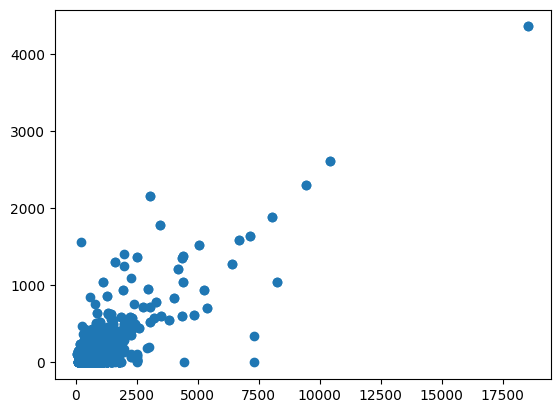

In [261]:
plt.scatter(bev['engagement'], bev['brandexposurevalue'])

In [268]:
X1, y1 = bev.drop(columns = ['brandexposurevalue']), bev['brandexposurevalue']

X1_const = sm.add_constant(X1)
result1 = sm.OLS(y1, X1_const).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     brandexposurevalue   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     919.4
Date:                Thu, 16 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:48:37   Log-Likelihood:                -20799.
No. Observations:                3366   AIC:                         4.162e+04
Df Residuals:                    3355   BIC:                         4.169e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -78.6562      4.368    -18.007      0.000     -87.221     -70.092
impressions               -0.0003   6.65e-05     -4.961      0.000      -0.000      -0.000
engagement                 0.2053      0.004     54.967      0.000       0.198       0.213
logoimpressions            0.0003   5.09e-05      6.511      0.000       0.000       0.000
asset_LED Courtside       28.2041      7.070      3.989      0.000      14.342      42.066
asset_On Court Signage    25.4784      6.024      4.230      0.000      13.668      37.289
asset_Pole Pad            -2.4265      6.437     -0.377      0.706     -15.048      10.195
asset_Scoreboard          24.8378     28.062      0.885      0.376     -30.182      79.857
asset_Seatbacks           34.0948     31.495      1.083      0.279     -27.657      95.847
asset_Upper Bowl LED      20.5157     21.694      0.946      0.344     -22.020      63.051
asset_Watermark          134.4943      5.695     23.616      0.000     123.328     145.660
==============================================================================
Omnibus:                     2681.395   Durbin-Watson:                   1.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           294052.147
Skew:                           3.099   Prob(JB):                         0.00
Kurtosis:                      48.368   Cond. No.                     1.42e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

In [33]:
# Copy merged dataframe
mg_cy_df = merged_df.copy(deep = True)

# Only get the data for the most recent snapshot_date for each brand exposure
mg_cy_df.sort_values(by = ['exposureid', 'postid', 'snapshot_date'], ascending = True, inplace = True)
mg_cy_df = mg_cy_df.groupby(by = ['exposureid', 'postid']).last().reset_index()

In [163]:
mg_cy_df[['partner', 'exposureid']].groupby(by = 'partner').count().reset_index().sort_values(by = ['exposureid'], ascending = False)

,partner,exposureid
3,coca_cola,4337
11,toyota,3200
2,citizens_bank,2080
0,chase,1403
5,delta_airlines,1140
9,miller_lite,757
6,draft_kings,730
13,verizon,645
1,chevrolet,584
10,motorola,524


In [34]:
mg_cy_df

,exposureid,postid,partner,channel,partnerexposuredate,contenttype,impressions,projectedimpressions,video_views,brandexposurevalue,...,asset,postvalue,feed_name,campaign,snapshot_date,game,exposure,duration,qimv,qi_sponsorship_impressions
0,000800a645dc1da03042d48bce642708753d897543dc7e...,78f9c8bf5b16dd3d70c006a8af53c1784c97543a50a71d...,coca_cola,twitter,2023-01-05 19:57:00,video,45812.0,NaN,8447.0,2.351878,...,None,1320.0,owned,None,2023-07-02 20:40:00,None,NaN,NaN,NaN,NaN
1,000c679175a79e03c36772dc88f16b52780ce79b504c40...,41128c3c63b4db058a57b78fba4b0ca4d96f233a6f0f92...,citizens_bank,twitter,2023-02-26 00:55:00,video,102615.0,NaN,24968.0,290.879400,...,on_court_signage,3890.0,owned,game_highlight,2023-07-02 20:41:00,None,NaN,NaN,NaN,NaN
2,0026d806457b2415deaf4f44964c04251e833fff5abc0e...,4565dee79fc19cee13ac54b0195e7f56b486150543de19...,toyota,twitter,2023-03-28 03:27:00,video,37425.0,NaN,7217.0,4.788782,...,led_courtside,1254.0,owned,None,2023-07-02 20:41:00,None,NaN,NaN,NaN,NaN
3,0029a6a7b18c2f757aafcfbd98cfff6f1457a069140d1d...,efd70a34a0c22f5036311bb7feb0779f984b7ea1563733...,verizon,twitter,2023-02-06 01:47:00,photo,46370.0,NaN,NaN,51.804160,...,None,1189.0,owned,None,2023-07-02 20:40:00,None,NaN,NaN,NaN,NaN
4,002bc9c13ac2bf4b4b6b27f204850e67d3fff823a3d2bd...,e2352a2cc5f2b6344945dd23feea7bfca130f13e8b9af9...,coca_cola,twitter,2023-01-01 03:05:00,video,43615.0,NaN,11356.0,0.297439,...,None,1625.0,owned,None,2023-07-02 20:40:00,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15903,zzgg8lobuaqzy7kgjk42z6op5yd5eca4g9cq3626w47ghe...,3e8c773c57afc4a835c508c7ba20d4435be364c4ca351b...,chevrolet,broadcast,2023-02-07 00:00:00,video,374357.0,NaN,87350.0,NaN,...,pole_pad,NaN,owned,None,2023-02-07 00:00:00,nj_devils,3.0,21.0,2219.0,40246.0
15904,zzjinjnvmp5dmpvxnqs0cvl02w6r9eow3l0berim1pho2h...,08538cb94fce9c7770717f4276120fb4ff8b6b54fb08ec...,chase,broadcast,2022-11-13 00:00:00,video,1163687.0,NaN,244987.0,NaN,...,pole_pad,NaN,owned,None,2022-11-13 00:00:00,cleveland_browns,19.0,120.0,4295.0,71454.0
15905,zzkazn62h91pku2jzy38dmkbgypbb6jk7wuv7kbo1dgjae...,c1fdfce8f2ff5f5dd2f313f1b8b4527c4f895734e546b7...,chase,twitter,2023-03-02 03:37:00,video,NaN,1336650.0,NaN,5.162294,...,None,26218.0,earned,None,2023-06-18 19:31:00,None,NaN,NaN,NaN,NaN
15906,zzmcoy9nzuaqkikrufy4wn9kjvndt93y47o6buf12zos1l...,cee60104257523c5d4c31a2a7ef293c29c45b547880974...,chevrolet,broadcast,2023-01-24 00:00:00,video,310712.0,NaN,98392.0,NaN,...,pole_pad,NaN,owned,None,2023-01-24 00:00:00,tampa_bay_lightning,2.0,19.0,2522.0,45272.0


In [61]:
# What owned content generates the highest engagement-to-impression ratio?
# -> If we can isolate one type of content where users interact a lot, they are more likely to see the brand
# Categories: campaign posts, channel, contenttype
mg_cy_df_v1 = mg_cy_df.copy(deep = True)
mg_cy_df_v1 = mg_cy_df_v1[mg_cy_df_v1['feed_name'] == 'owned']
mg_cy_df_v1['campaign'] = mg_cy_df_v1['campaign'].astype(bool)
mg_cy_df_v1 = mg_cy_df_v1[mg_cy_df_v1['channel'] != 'broadcast']

mg_cy_df_v1['better_impressions'] = pd.concat([mg_cy_df_v1['impressions'], mg_cy_df_v1['projectedimpressions']], axis = 1).max(axis = 1)
mg_cy_df_v1['engagement_to_impressions'] = 100 * (mg_cy_df_v1['engagement'] / mg_cy_df_v1['better_impressions'])

mg_cy_df_v1[['contenttype', 'feed_name', 'channel', 'campaign', 'engagement_to_impressions']].groupby(by = ['contenttype', 'feed_name', 'channel', 'campaign']).agg([len, np.mean]).reset_index()

C:\Users\chris\AppData\Local\Temp\ipykernel_12108\3733821595.py:12: FutureWarning: The provided callable <function mean at 0x00000257F34B8CC0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mg_cy_df_v1[['contenttype', 'feed_name', 'channel', 'campaign', 'engagement_to_impressions']].groupby(by = ['contenttype', 'feed_name', 'channel', 'campaign']).agg([len, np.mean]).reset_index()


contenttype feed_name  channel campaign engagement_to_impressions          
                                                                len      mean
0       photo     owned  twitter    False                       315  0.009325
1       photo     owned  twitter     True                       244  0.010009
2        text     owned  twitter    False                         7  0.003941
3        text     owned  twitter     True                         2  0.002553
4       video     owned  twitter    False                      5827  0.008982
5       video     owned  twitter     True                       106  0.012253
6       video     owned  youtube    False                        23  0.069153
7       video     owned  youtube     True                        36  0.047315

In [93]:
# What are the highest value assets? -> Who is buying them and has money to spend?
mg_cy_df_v2 = mg_cy_df.copy(deep = True)
mg_cy_df_v2 = mg_cy_df_v2[mg_cy_df_v2[['asset', 'postvalue', 'brandexposurevalue']].apply(lambda row: all(pd.notna(row)), axis = 1)]

pv_median , pv_iqr = np.median(mg_cy_df_v2['postvalue']), np.percentile(mg_cy_df_v2['postvalue'], 75) - np.percentile(mg_cy_df_v2['postvalue'], 25)
be_median, be_iqr = np.median(mg_cy_df_v2['brandexposurevalue']), np.percentile(mg_cy_df_v2['brandexposurevalue'], 75) - np.percentile(mg_cy_df_v2['brandexposurevalue'], 25)
mg_cy_df_v2['postvalue_standard'] = (mg_cy_df_v2['postvalue'] - pv_median) / pv_iqr
mg_cy_df_v2['brandexposurevalue_standard'] = (mg_cy_df_v2['brandexposurevalue'] - be_median) / be_iqr

v2_res = mg_cy_df_v2[['asset', 'postvalue_standard', 'brandexposurevalue_standard']].groupby(by = 'asset').median().reset_index()
v2_res['combo'] = v2_res['postvalue_standard'] + v2_res['brandexposurevalue_standard']
v2_res.sort_values(by = ['combo'], ascending = False)

,asset,postvalue_standard,brandexposurevalue_standard,combo
9,watermark,-0.159312,3.201105,3.041793
7,text_mention,-0.214169,1.256602,1.042433
1,led_courtside,0.790389,0.178828,0.969217
6,scoreboard,-0.087696,0.926865,0.839168
3,player_seatbacks,-0.158541,0.693172,0.534632
5,pole_pad,0.410107,-0.173694,0.236412
4,player_tunnel,0.408751,-0.247750,0.161001
2,on_court_signage,-0.018558,0.153203,0.134645
0,basket_stanchion,0.143278,-0.062860,0.080418
8,upper_bowl_led,-0.136032,-0.177326,-0.313358


In [94]:
mg_cy_df_v2[['asset', 'postvalue', 'brandexposurevalue']].groupby(by = 'asset').median().reset_index().sort_values(by = ['brandexposurevalue'], ascending = False)

,asset,postvalue,brandexposurevalue
9,watermark,1561.0,88.587650
7,text_mention,387.5,38.750935
6,scoreboard,3093.0,30.299920
3,player_seatbacks,1577.5,24.310495
1,led_courtside,21877.0,11.128080
2,on_court_signage,4572.0,10.471345
0,basket_stanchion,8034.0,4.933751
5,pole_pad,13742.0,2.093108
8,upper_bowl_led,2059.0,2.000026
4,player_tunnel,13713.0,0.195097


In [103]:
mg_cy_df_v1[mg_cy_df_v1['asset'].isin(['watermark', 'text_mention', 'scoreboard', 'player_seatbacks'])][['partner', 'asset', 'channel']].groupby(by = ['partner', 'asset']).count()#.reset_index().sort_values(by = ['asset'], ascending = False)

channel
partner         asset                    
chase           scoreboard             15
                text_mention            1
                watermark              86
chevrolet       text_mention            4
                watermark              14
citizens_bank   player_seatbacks       14
                text_mention            6
                watermark              58
coca_cola       text_mention            4
                watermark              16
delta_airlines  watermark             162
draft_kings     watermark              62
fanduel         watermark               9
miller_lite     watermark              20
motorola        watermark             122
toyota          scoreboard              1
                watermark              45
united_airlines text_mention            2
verizon         text_mention            2
                watermark              80

In [121]:
mg_cy_df[mg_cy_df['partner'] == 'motorola'][['channel', 'asset', 'contenttype', 'exposureid', 'feed_name']].groupby(by = ['channel', 'asset', 'contenttype', 'feed_name'], dropna = False).count()

exposureid
channel   asset          contenttype feed_name            
broadcast player_tunnel  video       owned               2
twitter   led_courtside  video       earned             70
                                     owned               8
          upper_bowl_led video       earned              8
                                     owned               1
          watermark      photo       owned               8
                         video       owned             114
          NaN            photo       owned               1
                         video       earned            138
                                     owned             174

In [140]:
# Partner-specific -> Motorola
motorola_df = mg_cy_df[mg_cy_df['partner'] == 'motorola'].copy(deep = True)
motorola_df['biweek_of_year'] = (pd.to_datetime(motorola_df[motorola_df['partner'] == 'motorola']['partnerexposuredate']).dt.isocalendar().week / 2).astype('int64')
motorola_df['better_impressions'] = pd.concat([motorola_df['impressions'], motorola_df['projectedimpressions']], axis = 1).max(axis = 1)

motorola_df[['biweek_of_year', 'better_impressions', 'video_views', 'engagement']].groupby(by = 'biweek_of_year').sum().reset_index()

,biweek_of_year,better_impressions,video_views,engagement
0,0,14541716.0,527293.0,36403.0
1,1,82107592.0,591897.0,89993.0
2,2,22229488.0,362760.0,33794.0
3,3,2633533.0,589336.0,20694.0
4,4,153712566.0,2142123.0,240614.0
5,5,3489562.0,559050.0,27219.0
6,6,732484.0,176409.0,6499.0
7,22,38212.0,5095.0,0.0
8,25,5990651.0,1515027.0,0.0
9,26,3084026.0,145205.0,7226.0


In [149]:
np.median(motorola_df[motorola_df['postvalue'].notna()]['postvalue'])

np.float64(3073.0)

In [148]:
motorola_df['postvalue']

13        1993.0
45        2736.0
50        1561.0
60        3440.0
83        1186.0
          ...   
15639     1561.0
15678     1880.0
15725    22433.0
15787    23753.0
15842    23324.0
Name: postvalue, Length: 524, dtype: float64

In [156]:
np.sum(motorola_df[motorola_df['feed_name'].notna()]['feed_name'] == 'owned')

np.int64(308)

In [158]:
308/524

0.5877862595419847

In [167]:
# Last visualization: Impressions, Proj_Impressions, Video_Views, Engagement overtime
lv_df = mg_cy_df.copy(deep = True)
lv_df['biweek_of_year'] = (pd.to_datetime(lv_df[lv_df['partner'] == 'motorola']['partnerexposuredate']).dt.isocalendar().week / 2).astype('int64')

lv_df[['biweek_of_year', 'impressions', 'projectedimpressions', 'video_views', 'engagement', 'exposureid']].groupby(by = 'biweek_of_year').count().reset_index()

,biweek_of_year,impressions,projectedimpressions,video_views,engagement,exposureid
0,0.0,46,10,46,56,56
1,1.0,67,69,66,136,136
2,2.0,34,17,33,51,51
3,3.0,39,0,36,39,39
4,4.0,57,117,55,174,174
5,5.0,31,1,30,32,32
6,6.0,18,0,18,18,18
7,22.0,1,0,1,0,1
8,25.0,1,0,1,0,1
9,26.0,14,2,13,16,16
